In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# custom
from module.DataLoader import DataLoader
from module.LightGCN import LightGCN, bpr_loss
from module.Eval_metrics import eval_metrics, recommend_k_items

%matplotlib inline

## Load the dataset

In [ ]:
path_dir = {
    "preprocessed_df_path": "./data/",
    "norm_adj_mat_path": "./preprocessed_data/norm_adj_mat.npz",
    "norm_adj_mat_chunk_path": "./preprocessed_data/norm_adj_mat_chunks/"
}

col_name = {"col_user":'user_id', "col_item":'parent_asin', "col_rating" : 'rating'}

train_df = pd.read_parquet("./dataset/filtered_train.parquet")
test_df = pd.read_parquet("./dataset/filtered_test.parquet")

data = DataLoader(train_df, test_df, path_dir, col_name)

## Model Building

In [ ]:
hyper_params = {"n_layers":3, "latent_dim":64}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lightGCN = LightGCN(data, hyper_params, device = device)
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

EPOCHS = 30
BATCH_SIZE = 128 # 2048 in this paper
DECAY = 0.0001
K = 20

Normalizing adjacency matrix in chunks...


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Combining chunks into the final normalized adjacency matrix...


/content/drive/MyDrive/CS/BOAZ_rec/module/LightGCN.py:39: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  return torch.sparse.FloatTensor(i, v, torch.Size(shape))


## Training

In [ ]:
# Training setup
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

for epoch in tqdm(range(EPOCHS), desc="Training Epochs"):
    n_batch = len(train_df) // BATCH_SIZE

    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []

    best_ndcg = -1

    lightGCN.train()

    for batch_idx in range(n_batch):
      optimizer.zero_grad()

      users, pos_items, neg_items = data.train_loader(BATCH_SIZE)
      users = torch.tensor(users, dtype=torch.long, device=device)
      pos_items = torch.tensor(pos_items, dtype=torch.long, device=device)
      neg_items = torch.tensor(neg_items, dtype=torch.long, device=device)

      users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

      mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
      reg_loss = DECAY * reg_loss
      final_loss = mf_loss + reg_loss


      final_loss.backward()
      optimizer.step()

      final_loss_list.append(final_loss.item())
      MF_loss_list.append(mf_loss.item())
      reg_loss_list.append(reg_loss.item())

    lightGCN.eval()

    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.LightGraphConvolution_operation()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = eval_metrics(col_name, data.train_df, data.test_df, data.n_users, data.n_items, final_user_Embed, final_item_Embed, BATCH_SIZE, K)

    if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg

        torch.save(final_user_Embed, './Embedded/final_user_Embed.pt')
        torch.save(final_item_Embed, './Embedded/final_item_Embed.pt')

    loss_list_epoch.append(round(np.mean(final_loss_list), 4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list), 4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    print(f"Loss in in epoch {epoch+1}:  {round(np.mean(final_loss_list), 4)}.")

Training Epochs:   3%|▎         | 1/30 [00:01<00:37,  1.30s/it]

Loss in in epoch 1:  0.6437.



Training Epochs:   7%|▋         | 2/30 [00:02<00:32,  1.16s/it]

Loss in in epoch 2:  0.3875.



Training Epochs:  10%|█         | 3/30 [00:03<00:29,  1.11s/it]

Loss in in epoch 3:  0.2366.



Training Epochs:  13%|█▎        | 4/30 [00:04<00:27,  1.07s/it]

Loss in in epoch 4:  0.1796.



Training Epochs:  17%|█▋        | 5/30 [00:05<00:27,  1.09s/it]

Loss in in epoch 5:  0.1453.



Training Epochs:  20%|██        | 6/30 [00:06<00:23,  1.01it/s]

Loss in in epoch 6:  0.1194.



Training Epochs:  23%|██▎       | 7/30 [00:07<00:20,  1.11it/s]

Loss in in epoch 7:  0.0975.



Training Epochs:  27%|██▋       | 8/30 [00:07<00:18,  1.17it/s]

Loss in in epoch 8:  0.0939.



Training Epochs:  30%|███       | 9/30 [00:08<00:17,  1.22it/s]

Loss in in epoch 9:  0.0802.



Training Epochs:  33%|███▎      | 10/30 [00:09<00:15,  1.28it/s]

Loss in in epoch 10:  0.0695.



Training Epochs:  37%|███▋      | 11/30 [00:10<00:14,  1.30it/s]

Loss in in epoch 11:  0.0671.



Training Epochs:  40%|████      | 12/30 [00:10<00:15,  1.20it/s]

Loss in in epoch 12:  0.0592.



Training Epochs:  43%|████▎     | 13/30 [00:11<00:13,  1.24it/s]

Loss in in epoch 13:  0.0546.



Training Epochs:  47%|████▋     | 14/30 [00:12<00:12,  1.27it/s]

Loss in in epoch 14:  0.0549.



Training Epochs:  50%|█████     | 15/30 [00:13<00:12,  1.21it/s]

Loss in in epoch 15:  0.0536.



Training Epochs:  53%|█████▎    | 16/30 [00:14<00:11,  1.25it/s]

Loss in in epoch 16:  0.0416.



Training Epochs:  57%|█████▋    | 17/30 [00:14<00:10,  1.29it/s]

Loss in in epoch 17:  0.0372.



Training Epochs:  60%|██████    | 18/30 [00:15<00:09,  1.29it/s]

Loss in in epoch 18:  0.0384.



Training Epochs:  63%|██████▎   | 19/30 [00:16<00:09,  1.17it/s]

Loss in in epoch 19:  0.0421.



Training Epochs:  67%|██████▋   | 20/30 [00:17<00:09,  1.10it/s]

Loss in in epoch 20:  0.0398.



Training Epochs:  70%|███████   | 21/30 [00:18<00:08,  1.04it/s]

Loss in in epoch 21:  0.0392.



Training Epochs:  73%|███████▎  | 22/30 [00:19<00:08,  1.00s/it]

Loss in in epoch 22:  0.0306.



Training Epochs:  77%|███████▋  | 23/30 [00:20<00:06,  1.06it/s]

Loss in in epoch 23:  0.0303.



Training Epochs:  80%|████████  | 24/30 [00:21<00:05,  1.12it/s]

Loss in in epoch 24:  0.0288.



Training Epochs:  83%|████████▎ | 25/30 [00:22<00:04,  1.18it/s]

Loss in in epoch 25:  0.0252.



Training Epochs:  87%|████████▋ | 26/30 [00:22<00:03,  1.20it/s]

Loss in in epoch 26:  0.0263.



Training Epochs:  90%|█████████ | 27/30 [00:23<00:02,  1.24it/s]

Loss in in epoch 27:  0.0234.



Training Epochs:  93%|█████████▎| 28/30 [00:24<00:01,  1.26it/s]

Loss in in epoch 28:  0.0237.



Training Epochs:  97%|█████████▋| 29/30 [00:25<00:00,  1.31it/s]

Loss in in epoch 29:  0.0221.



Training Epochs: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]

Loss in in epoch 30:  0.0256.


## Results

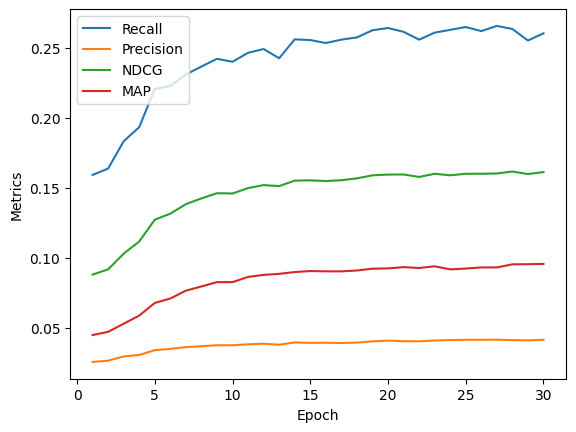

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

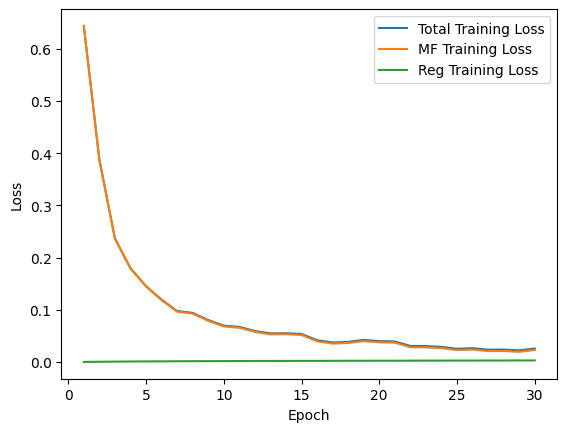

In [ ]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
user_Embed = torch.load('./Embedded/final_user_Embed.pt')
item_Embed = torch.load('./Embedded/final_item_Embed.pt')

In [ ]:
recommend_k_items(col_name, data.train_df, data.test_df, data.n_users, data.n_items, user_Embed, item_Embed, 128, 10)

Get relevance score: 100%|██████████| 7/7 [00:00<00:00, 71.97it/s]


,user_id,top_relevent_item
0,0,"[512, 241, 508, 231, 221, 339, 585, 296, 224, ..."
1,1,"[102, 103, 81, 83, 189, 139, 208, 85, 89, 26]"
2,2,"[245, 115, 246, 111, 17, 85, 208, 113, 249, 83]"
3,4,"[454, 290, 435, 280, 291, 746, 164, 508, 744, ..."
4,6,"[96, 353, 57, 90, 15, 110, 441, 327, 117, 258]"
...,...,...
580,828,"[54, 346, 434, 342, 522, 272, 540, 343, 493, 284]"
581,829,"[82, 91, 92, 248, 83, 249, 39, 338, 190, 99]"
582,830,"[528, 540, 15, 72, 97, 514, 407, 784, 729, 722]"
583,831,"[78, 73, 252, 210, 77, 98, 209, 206, 115, 82]"
